##  Machine Learning for Thyroid Cancer Diagnosis.
##  Part 1: Data visualization
**The project was done with Rajiv Krishnakumar and Raghu Mahajan.**

The essential goal was to predict thyroid cancer given gene expressions. A key hope is to definitively predict benign samples; this helps to avoid unnecessary surgeries, which often turn out to be much more problematic to a patient's health, than the thyroid cancer itself.


- The data used here is pre-normalized, to mean zero and standard deviation 1. 
- The essentials of the data set are 265 patients whose biopsies were inconclusive, each with 173 reported gene expression levels. 
- There were a further 102 patients with 'conclusive' biopsies - i.e. a human determination of benign vs. malignant, to give 367 total patients.

Here is an abstract from our final report:

*We investigate the use of high throughput gene expression data in the diagnosis of thyroid cancers. Using logistic regression and support vector machines (SVMs), we develop a classifier which gives similar performance (89% sensitivity and 80% specificity) to the currently best- known classifier, but uses significantly fewer features. We used two different techniques, principal components analysis and mutual information score, to select features. The results do not depend significantly on which method is used for feature selection.*

The breakdown of topics covered in each notebook is as follows:
1. Data visualization, including PCA and tSNE visualizations.
2. Logistic regression, discussing the use of feature selection via mutual information vs. use of different regularizers.
3. SVMs with and without box constraints, and also using different kernel functions.

In [46]:
#As usual import some modules and import the dataset
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#import the data and look at it
X = pd.read_csv("data/normalized_data_265.csv", header =None)
y = pd.read_csv("data/outcome_265.csv", header = None)

X_full = pd.read_csv("data/normalized_data_367.csv", header =None)
y_full = pd.read_csv("data/outcome_367.csv", header = None)


X.head()

,0,1,2,3,4,5,6,7,8,9,...,163,164,165,166,167,168,169,170,171,172
0,0.17946,-0.92523,-0.69370,0.46983,-0.348710,-0.21465,-0.30662,1.35960,-0.50597,1.10310,...,0.068605,-0.53499,0.3080,-0.33358,0.82609,0.025969,-0.70057,-0.70648,0.46854,0.34735
1,1.31370,-0.44796,0.12014,-0.64247,0.093455,-0.40658,-0.61403,-0.48841,0.77221,-0.68340,...,-1.142500,2.13830,-1.0025,-1.21120,0.82492,-0.013805,0.79090,1.27370,0.92238,1.19300
2,-0.38540,1.07300,-1.03730,0.48228,0.501700,0.43634,0.77020,-0.13205,-1.65490,0.57408,...,0.162620,-0.12682,1.5029,0.82987,-0.71825,0.016890,-0.73851,-0.68747,-1.05070,-0.87795
3,-0.20878,0.16227,1.00610,-0.49424,-0.360830,0.67324,-0.11529,0.80011,-1.14330,0.74535,...,0.278480,-1.07120,-1.5862,0.30024,0.25210,0.831140,2.35430,-0.86967,-0.17322,-0.45560
4,-2.51940,-0.60297,-1.46150,1.31050,-1.264400,-0.77405,-0.18420,-1.05920,-1.12240,-1.93630,...,-0.014778,-0.73844,1.3451,0.70413,-3.20790,-2.959900,-0.53812,-0.66792,-3.29540,-3.41680


### Data visualization and exploration for 265 "indeterminate" samples
Here we use the first two principal compenents from a PCA, as well as the *fancier* tSNE method for visualization using only the 265 patients with inconclusive biopsies.

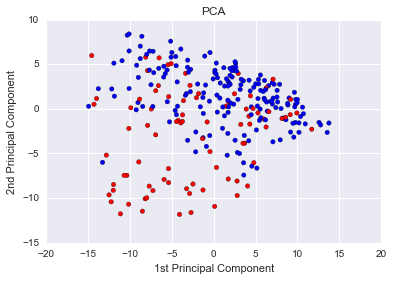

In [47]:
#PCA visualization

#First import the sklearn module
from sklearn import decomposition

#Use the same seed for repeatable results
np.random.seed(5)

#Create and run the PCA object
pca = decomposition.PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

sns.plt.title("PCA")
sns.plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=plt.get_cmap('bwr'))
sns.plt.xlabel("1st Principal Component")
sns.plt.ylabel("2nd Principal Component")

From PCA, seems like one can definitely draw a rough line of separation between malignant (red) and benign (blue) samples. However they are clearly not linearly separable.

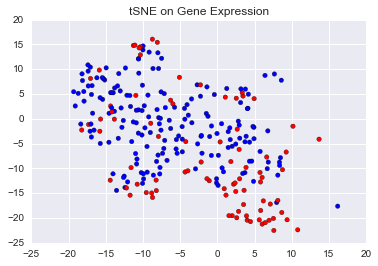

In [48]:
#tSNE visualization

#import tSNE module
from sklearn.manifold import TSNE

#convert data frame to a numpy array
Xnp = X.as_matrix()
np.random.seed(2)
tSNE_model = TSNE(n_components=2, learning_rate = 500, n_iter = 20000)
X_tSNE = tSNE_model.fit_transform(Xnp)

sns.plt.title("tSNE on Gene Expression")
sns.plt.scatter(X_tSNE[:, 0], X_tSNE[:, 1], c=y, cmap=plt.get_cmap('bwr'))

The tSNE visualization is promising - once more there are definite clusters of malignant samples. Unfortunately there are no islands of definitively benign samples.

**Finally, let us try tSNE on PCA'd data.** 
This is a little weird: PCA looks for the highest variance directions, while tSNE clusters points which are "close by" in the high dimensional manifold. So we are projecting onto a basis where the variance is highest (via PCA), and then clustering data in that high dimensional space.

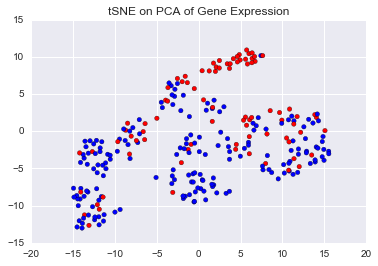

In [55]:
#convert data frame to a numpy array
Xnp_pca = X_pca
np.random.seed(4)
tSNE_pca_model = TSNE(n_components=2, learning_rate = 2000, n_iter = 20000)
X_pca_tSNE = tSNE_model.fit_transform(Xnp_pca)


sns.plt.title("tSNE on PCA of Gene Expression")
sns.plt.scatter(X_pca_tSNE[:, 0], X_pca_tSNE[:, 1], c=y, cmap=plt.get_cmap('bwr'))

Wow! - some very strong clustering here. Again - there isn't *very* clear separtion between Malignant and Benign samples, but there is at least one clear cluster of malignancy, and one clear cluster of benign samples.

### Data visualization and exploration for all 367 samples
Let us now repeat the above steps for all 367 samples in the dataset

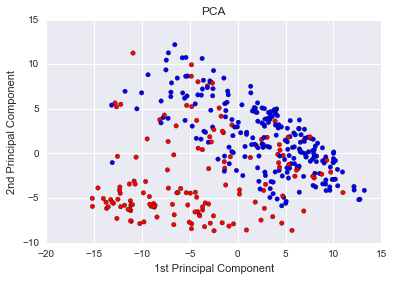

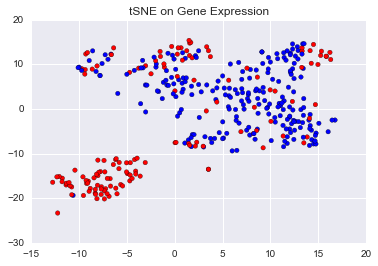

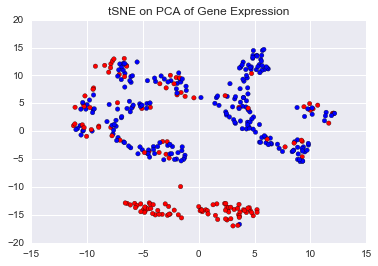

In [56]:
#Use the same seed for repeatable results
np.random.seed(5)

#Create and run the PCA object
pca = decomposition.PCA(n_components=2)
pca.fit(X_full)
X_full_pca = pca.transform(X_full)

sns.plt.figure()
sns.plt.title("PCA")
sns.plt.scatter(X_full_pca[:, 0], X_full_pca[:, 1], c=y_full, cmap=plt.get_cmap('bwr'))
sns.plt.xlabel("1st Principal Component")
sns.plt.ylabel("2nd Principal Component")


#convert data frame to a numpy array
Xnp_full = X_full.as_matrix()
np.random.seed(2)
tSNE_model = TSNE(n_components=2, learning_rate = 500, n_iter = 20000)
X_full_tSNE = tSNE_model.fit_transform(Xnp_full)
sns.plt.figure()
sns.plt.title("tSNE on Gene Expression")
sns.plt.scatter(X_full_tSNE[:, 0], X_full_tSNE[:, 1], c=y_full, cmap=plt.get_cmap('bwr'))


np.random.seed(2)
tSNE_pca_model = TSNE(n_components=2, learning_rate = 2000, n_iter = 20000)
X_full_pca_tSNE = tSNE_model.fit_transform(X_full_pca)
sns.plt.figure()
sns.plt.title("tSNE on PCA of Gene Expression")
sns.plt.scatter(X_full_pca_tSNE[:, 0], X_full_pca_tSNE[:, 1], c=y_full, cmap=plt.get_cmap('bwr'))